<a href="https://colab.research.google.com/github/baizhankyzy/female-directors/blob/main/Project_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our Goal

To discover trends in the role of female directors in cinema by analyzing their activity across different countries and examining movie databases for specific periods of study. This will include exploring the role of independent cinema as a pathway for women directors. The research will uncover patterns of representation, contributions, and shifts over time.

## Converting JSON file from Wikidata to n-quads format graph

In [ ]:
!pip install rdflib
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
from urllib.parse import quote
import requests
from google.colab import files

# Fetch the JSON data
url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dataset_final.json"
response = requests.get(url)
data = response.json()['results']['bindings']

# Initialize the graph
g = ConjunctiveGraph()

# Define namespaces
wd = Namespace("http://www.wikidata.org/entity/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
wikidata = URIRef("http://example.org/graph/wikidata")  # Explicitly set graph name

# Add data to the graph
for item in data:
    film = URIRef(item['film']['value'])
    director = URIRef(item['director']['value'])
    release_year = Literal(item['releaseYear']['value'], datatype=RDFS.Literal)
    film_label = Literal(item['filmLabel']['value'], lang='en')
    director_label = Literal(item['directorLabel']['value'], lang='en')

    genre_label = item.get('genreLabel', {}).get('value', "Unknown Genre")
    genre_uri = URIRef(f"http://www.wikidata.org/genre/{quote(genre_label)}")

    country_label = item.get('countryOfBirthLabel', {}).get('value', "Unknown Country")
    country_uri = URIRef(f"http://www.wikidata.org/country/{quote(country_label)}")

    # Avoid blank nodes by always ensuring explicit URIs or Literals
    if isinstance(film, URIRef) and isinstance(director, URIRef):
        # Add RDF quads with the graph name
        g.add((film, wdt.P31, wd.Q11424, wikidata))  # Film type
        g.add((film, RDFS.label, film_label, wikidata))
        g.add((film, wdt.P57, director, wikidata))
        g.add((film, wdt.P577, release_year, wikidata))
        g.add((film, wdt.P136, genre_uri, wikidata))
        g.add((film, wdt.P19, country_uri, wikidata))
        g.add((director, RDFS.label, director_label, wikidata))
        g.add((genre_uri, RDFS.label, Literal(genre_label, lang='en'), wikidata))
        g.add((country_uri, RDFS.label, Literal(country_label, lang='en'), wikidata))

# Serialize the graph to N-Quads
output_file = "wikidata_graph.nq"
g.serialize(output_file, format="nquads")

# Download the file
files.download(output_file)
print(f"Data saved as {output_file} and ready for download.")

<ipython-input-63-41a2ea48f2fe>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


KeyboardInterrupt: 

## Fetching data from DBpedia and converting it into nquads

In [ ]:
!pip install SPARQLWrapper
!pip install rdflib

from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from google.colab import files

# Step 1: Define the endpoint and query
endpoint_url = "https://dbpedia.org/sparql"
sparql_query = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?movie ?movieLabel ?distributor ?distributorLabel ?budget ?boxOffice ?releaseDate ?director ?directorLabel
WHERE {
  ?movie a dbo:Film ;
         dbo:releaseDate ?releaseDate ;
         dbo:distributor ?distributor ;
         dbo:director ?director .

  OPTIONAL { ?movie dbo:budget ?budget . }
  OPTIONAL { ?movie dbo:gross ?boxOffice . }
  OPTIONAL { ?director rdfs:label ?directorLabel . }
  ?movie rdfs:label ?movieLabel .
  ?distributor rdfs:label ?distributorLabel .

  FILTER (xsd:date(?releaseDate) >= "1994-01-01"^^xsd:date && xsd:date(?releaseDate) <= "2024-12-31"^^xsd:date)
  FILTER (lang(?movieLabel) = "en" && lang(?distributorLabel) = "en" && lang(?directorLabel) = "en")
}
ORDER BY ?releaseDate
"""

# Step 2: Send the query to DBpedia
sparql = SPARQLWrapper(endpoint_url)
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)  # Get results in JSON format
results = sparql.query().convert()

# Step 3: Initialize a ConjunctiveGraph for N-Quads conversion
g = ConjunctiveGraph()
dbpedia_graph = URIRef("http://example.org/graph/dbpedia")  # Assign a graph name

# Step 4: Add results to the graph
for result in results["results"]["bindings"]:
    # Extract required fields
    movie = URIRef(result["movie"]["value"])
    release_date = Literal(result["releaseDate"]["value"], datatype=XSD.date)

    # Add required triples
    g.add((movie, RDF.type, URIRef("http://dbpedia.org/ontology/Film"), dbpedia_graph))
    g.add((movie, URIRef("http://dbpedia.org/ontology/releaseDate"), release_date, dbpedia_graph))

    # Add optional triples with checks for empty values
    if "movieLabel" in result and result["movieLabel"]["value"].strip():
        movie_label = Literal(result["movieLabel"]["value"], lang="en")
        g.add((movie, RDFS.label, movie_label, dbpedia_graph))

    if "distributor" in result and "distributorLabel" in result:
        distributor = URIRef(result["distributor"]["value"])
        distributor_label = result["distributorLabel"]["value"].strip()
        if distributor_label:
            g.add((movie, URIRef("http://dbpedia.org/ontology/distributor"), distributor, dbpedia_graph))
            g.add((distributor, RDFS.label, Literal(distributor_label, lang="en"), dbpedia_graph))

    if "budget" in result and result["budget"]["value"].strip():
        budget = Literal(result["budget"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/budget"), budget, dbpedia_graph))

    if "boxOffice" in result and result["boxOffice"]["value"].strip():
        box_office = Literal(result["boxOffice"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/gross"), box_office, dbpedia_graph))

    if "director" in result:
        director = URIRef(result["director"]["value"])
        g.add((movie, URIRef("http://dbpedia.org/ontology/director"), director, dbpedia_graph))

        if "directorLabel" in result and result["directorLabel"]["value"].strip():
            director_label = Literal(result["directorLabel"]["value"], lang="en")
            g.add((director, RDFS.label, director_label, dbpedia_graph))

# Step 5: Serialize the graph to N-Quads
output_file = "dbpedia_graph.nq"
g.serialize(output_file, format="nquads")

print(f"N-Quads data saved to {output_file}.")

# Download the file
files.download(output_file)




<ipython-input-5-0c3b5135ccf7>:43: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


N-Quads data saved to dbpedia_graph.nq.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reconciling graphs

In [ ]:
!pip install rdflib
!pip install requests
from rdflib import ConjunctiveGraph, URIRef, Namespace, Literal
from rdflib.namespace import OWL
import requests
from google.colab import files

# URLs for the N-Quads files
wikidata_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"
dbpedia_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq"

# Load graphs using ConjunctiveGraph
wikidata_graph = ConjunctiveGraph()
dbpedia_graph = ConjunctiveGraph()

# Download and parse the graphs with error handling
for url, graph in [(wikidata_url, wikidata_graph), (dbpedia_url, dbpedia_graph)]:
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error if the request fails
        graph.parse(data=response.text, format="nquads")
        print(f"Graph loaded successfully from {url}, contains {len(graph)} triples/quads.")
    except Exception as e:
        print(f"Error parsing graph from {url}: {e}")

# Define namespaces
owl = Namespace("http://www.w3.org/2002/07/owl#")

# Create a reconciliation graph with a named context
reconciliation_context = URIRef("http://example.org/graph/reconciliation")
reconciliation_graph = ConjunctiveGraph()

# Define predicates for labels and directors
wikidata_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
dbpedia_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
wikidata_director_predicate = URIRef("http://www.wikidata.org/prop/direct/P57")
dbpedia_director_predicate = URIRef("http://dbpedia.org/ontology/director")

# Helper function to clean labels (removes "(director)" from DBpedia labels)
def clean_label(label):
    if " (director)" in label:
        return label.replace(" (director)", "").strip()
    return label

# Build an index for DBpedia director labels
dbpedia_director_labels = {}
print("\nBuilding DBpedia director labels index...")
for director, _, label, _ in dbpedia_graph.quads((None, dbpedia_label_predicate, None, None)):
    if director not in dbpedia_director_labels:
        dbpedia_director_labels[director] = clean_label(label)
print(f"Indexed {len(dbpedia_director_labels)} DBpedia directors.")

# Match directors by cleaned labels
match_count = 0
print("\nStarting reconciliation...")
for film, _, director, graph in wikidata_graph.quads((None, wikidata_director_predicate, None, None)):
    for _, _, label, _ in wikidata_graph.quads((director, wikidata_label_predicate, None, None)):
        cleaned_label = clean_label(label)
        # Check against DBpedia index
        for dbpedia_director, dbpedia_label in dbpedia_director_labels.items():
            if cleaned_label.lower() == dbpedia_label.lower():
                print(f"Match Found: {cleaned_label} (Wikidata) == {dbpedia_label} (DBpedia)")
                # Add to reconciliation graph with the specified context
                reconciliation_graph.add((director, OWL.sameAs, dbpedia_director, reconciliation_context))
                match_count += 1

print(f"\nTotal matches found: {match_count}")

# Check if reconciliation graph is empty
if len(reconciliation_graph) == 0:
    print("The reconciliation graph is empty.")
else:
    print(f"The reconciliation graph contains {len(reconciliation_graph)} triples/quads.")

# Serialize the reconciled graph to N-Quads
output_file = "reconciled_graph.nq"
try:
    reconciliation_graph.serialize(output_file, format="nquads")
    print(f"Reconciled graph saved to {output_file}.")
except Exception as e:
    print(f"Error saving reconciled graph: {e}")

# Print all quads in the reconciliation graph
print("\nReconciliation Graph Contents:")
for subject, predicate, obj, graph in reconciliation_graph.quads((None, None, None, None)):
    print(f"Subject: {subject}, Predicate: {predicate}, Object: {obj}, Graph: {graph}")

# Download the file
try:
    files.download(output_file)
    print(f"Data saved as {output_file} and ready for download.")
except Exception as e:
    print(f"Error downloading file: {e}")

<ipython-input-6-4cbaa31bff61>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  wikidata_graph = ConjunctiveGraph()
<ipython-input-6-4cbaa31bff61>:14: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  dbpedia_graph = ConjunctiveGraph()


Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq, contains 117560 triples/quads.
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq, contains 10952 triples/quads.

Building DBpedia director labels index...
Indexed 3549 DBpedia directors.

Starting reconciliation...


<ipython-input-6-4cbaa31bff61>:31: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  reconciliation_graph = ConjunctiveGraph()


Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agniesz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data saved as reconciled_graph.nq and ready for download.


# Loading the wikidata graph

Download wikidata graph from github to Google Colab

In [1]:
!pip install rdflib
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")

# Now you can query the graph


File wikidata_graph.nq downloaded successfully.


<ipython-input-1-7c1b4204f52d>:22: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


Graph loaded successfully.


## Research questions
### 1. How has the number of women directors in feature films changed over the last 30 years?



**Filtering data for research question**

In [3]:
# Iterate through each year from 1994 to 2024 and count films
print("Year\tNumber of Films")
for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    SELECT (COUNT(?film) AS ?film_count)
    WHERE {{
      ?film <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q11424> .
      ?film <http://www.wikidata.org/prop/direct/P577> "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .
    }}
    """

    # Execute the query
    results = g.query(query)

    # Print the result for the current year
    for row in results:
        print(f"{year}\t{row['film_count']}")

Total number of unique directors: 9258
No duplicates found in the list.
List of unique directors:
['Leslie Zemeckis', 'Mireia Gabilondo', 'Halitha shameem', 'Gigi Gaston', 'Yukiko Mishima', 'Caroline Sascha Cogez', 'Maria Essén', 'Bonnie Rotten', 'Marsia Tzivara', 'Rachel Reichman', 'Colombe Schneck', 'Kanika Verma', 'Linda-Maria Birbeck', 'Ghyslaine Côté', 'Susanne Müller', 'Ginger Gentile', 'Sandra Fernández Ferreira', 'Liu Jiayin', 'Maja Classen', 'Silja Somby', 'Pilar Palomero', 'Jennifer Elster', 'Sandrine Veysset', 'Antoinette Jadaone', 'Inés Toharia Terán', 'Ulrike Ottinger', 'Brigitte Maria Mayer', 'Sólveig Anspach', 'Mariana Chenillo', 'Houda Benyamina', 'Mandie Fletcher', 'Marie-Louise Asseu', 'Susana Nobre', 'Chiara Edmands', 'April Mullen', 'Alina Marazzi', 'Mélanie Carrier', 'Marta Ferencová', 'Emily Atef', 'Eva Dahr', 'İlksen Başarır', 'Natalia Bodiul', 'Gina Kim', 'Marisa Sistach', 'Sophie Fillières', 'Naomi Kawase', 'Isabel Kleefeld', 'Omoni Oboli', 'Maria Martinelli', 

# IMDb

## 1. Extracting all the names of the directors from the graph

In [2]:
# Load RDF data (replace 'data.rdf' with your RDF file or URL)
g.parse("wikidata_graph.nq")

# Define the SPARQL query with appropriate prefixes
query = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>

SELECT DISTINCT (STR(?directorName) AS ?name)  # Use DISTINCT to avoid duplicates in the query results
WHERE {
  ?film wdt:P31 wd:Q11424 .  # Film
  ?film wdt:P57 ?director .  # Director
  ?director rdfs:label ?directorName .
}
"""

# Execute the query
results = g.query(query)

# Create a list of director names (allowing duplicates from query results initially)
director_names_list = [str(row.name) for row in results]

# Remove duplicates from the list by converting it to a set and back to a list
director_names_list = list(dict.fromkeys(director_names_list))  # Preserves order while removing duplicates

# Count and print the number of unique directors
num_directors = len(director_names_list)
print(f"Total number of unique directors: {num_directors}")

# Check for duplicates again
if len(director_names_list) == len(set(director_names_list)):
    print("No duplicates found in the list.")
else:
    print("Duplicates found in the list.")

# Print the list of directors (optional)
print("List of unique directors:")
print(director_names_list)

Total number of unique directors: 9258
No duplicates found in the list.
List of unique directors:
['Leslie Zemeckis', 'Mireia Gabilondo', 'Halitha shameem', 'Gigi Gaston', 'Yukiko Mishima', 'Caroline Sascha Cogez', 'Maria Essén', 'Bonnie Rotten', 'Marsia Tzivara', 'Rachel Reichman', 'Colombe Schneck', 'Kanika Verma', 'Linda-Maria Birbeck', 'Ghyslaine Côté', 'Susanne Müller', 'Ginger Gentile', 'Sandra Fernández Ferreira', 'Liu Jiayin', 'Maja Classen', 'Silja Somby', 'Pilar Palomero', 'Jennifer Elster', 'Sandrine Veysset', 'Antoinette Jadaone', 'Inés Toharia Terán', 'Ulrike Ottinger', 'Brigitte Maria Mayer', 'Sólveig Anspach', 'Mariana Chenillo', 'Houda Benyamina', 'Mandie Fletcher', 'Marie-Louise Asseu', 'Susana Nobre', 'Chiara Edmands', 'April Mullen', 'Alina Marazzi', 'Mélanie Carrier', 'Marta Ferencová', 'Emily Atef', 'Eva Dahr', 'İlksen Başarır', 'Natalia Bodiul', 'Gina Kim', 'Marisa Sistach', 'Sophie Fillières', 'Naomi Kawase', 'Isabel Kleefeld', 'Omoni Oboli', 'Maria Martinelli', 

## 2. Search these names in IMDb

In [3]:
import requests
from bs4 import BeautifulSoup
import time
import csv

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Function to search IMDb and extract the director's IMDb page
def search_imdb_for_director(director_name):
    try:
        # Construct the IMDb search URL
        search_url = f"https://www.imdb.com/find/?q={'+'.join(director_name.split())}&s=nm"

        # Send the GET request
        response = requests.get(search_url, headers=headers)
        if response.status_code != 200:
            return None

        # Parse the HTML content
        soup = BeautifulSoup(response.content, "html.parser")

        # Locate the desired block and extract the IMDb page link
        result = soup.find('li', class_='ipc-metadata-list-summary-item ipc-metadata-list-summary-item--click find-result-item find-name-result')
        if result:
            link = result.find('a', class_='ipc-metadata-list-summary-item__t')
            if link and 'href' in link.attrs:
                return "https://www.imdb.com" + link['href']
        return None
    except Exception:
        return None

# Process the director_names list (already exists from your query)
# Example: director_names = ["Leslie Zemeckis", "Mira Thiel", "Amy J. Berg"]

imdb_results = []
for director in director_names_list:  # Use the existing list without specifying items
    director = director.strip()  # Clean up whitespace

    # Search IMDb
    imdb_page = search_imdb_for_director(director)
    result = {"Director": director, "IMDb Page": imdb_page if imdb_page else "Not Found"}
    imdb_results.append(result)

    # Print result for each director
    print(f"Director: {result['Director']}, IMDb Page: {result['IMDb Page']}")

    # Add delay to avoid rate-limiting
    time.sleep(2)

# Save results to a CSV file
with open("directors_imdb_pages.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=["Director", "IMDb Page"])
    writer.writeheader()
    writer.writerows(imdb_results)

print("Results saved to 'directors_imdb_pages.csv'")


Director: Leslie Zemeckis, IMDb Page: https://www.imdb.com/name/nm0366667/?ref_=fn_nme_nme_1
Director: Mireia Gabilondo, IMDb Page: https://www.imdb.com/name/nm1481127/?ref_=fn_nme_nme_1
Director: Halitha shameem, IMDb Page: https://www.imdb.com/name/nm6274646/?ref_=fn_nme_nme_1
Director: Gigi Gaston, IMDb Page: https://www.imdb.com/name/nm0309456/?ref_=fn_nme_nme_1
Director: Yukiko Mishima, IMDb Page: https://www.imdb.com/name/nm3446966/?ref_=fn_nme_nme_1
Director: Caroline Sascha Cogez, IMDb Page: https://www.imdb.com/name/nm0169032/?ref_=fn_nme_nme_1
Director: Maria Essén, IMDb Page: https://www.imdb.com/name/nm0261345/?ref_=fn_nme_nme_1
Director: Bonnie Rotten, IMDb Page: https://www.imdb.com/name/nm6720874/?ref_=fn_nme_nme_1
Director: Marsia Tzivara, IMDb Page: https://www.imdb.com/name/nm3103786/?ref_=fn_nme_nme_1
Director: Rachel Reichman, IMDb Page: https://www.imdb.com/name/nm0717116/?ref_=fn_nme_nme_1
Director: Colombe Schneck, IMDb Page: https://www.imdb.com/name/nm4073812/?

KeyboardInterrupt: 

In [3]:
import requests
from bs4 import BeautifulSoup
import csv
import os

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Function to search IMDb and extract the director's IMDb page
def search_imdb_for_director(director_name):
    try:
        search_url = f"https://www.imdb.com/find/?q={'+'.join(director_name.split())}&s=nm"
        response = requests.get(search_url, headers=headers, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, "html.parser")
        result = soup.find('li', class_='ipc-metadata-list-summary-item ipc-metadata-list-summary-item--click find-result-item find-name-result')
        if result:
            link = result.find('a', class_='ipc-metadata-list-summary-item__t')
            if link and 'href' in link.attrs:
                return {"Director": director_name, "IMDb Page": "https://www.imdb.com" + link['href']}
        return {"Director": director_name, "IMDb Page": "Not Found"}
    except requests.exceptions.RequestException as e:
        print(f"Network error for {director_name}: {e}")
        return {"Director": director_name, "IMDb Page": "Not Found"}

# Function to save results to a CSV file
def save_progress_to_csv(results, filename="directors_imdb_pages.csv"):
    # Check if the file already exists to append data
    file_exists = os.path.exists(filename)
    with open(filename, "a" if file_exists else "w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Director", "IMDb Page"])
        if not file_exists:
            writer.writeheader()  # Write header only if the file is new
        writer.writerows(results)

# Function to process a chunk of directors
def process_chunk(director_chunk, filename="directors_imdb_pages.csv"):
    chunk_results = []
    for director in director_chunk:
        director = director.strip()  # Clean up any extra spaces or formatting
        imdb_page = search_imdb_for_director(director)
        result = {"Director": director, "IMDb Page": imdb_page if imdb_page else "Not Found"}
        chunk_results.append(result)
        print(f"Director: {result['Director']}, IMDb Page: {result['IMDb Page']}")
    save_progress_to_csv(chunk_results, filename)

# Example director list (replace with your actual data)
# director_names_list = [...]

# Split the list into smaller chunks (e.g., 50 names per chunk)
chunk_size = 50
chunks = [director_names_list[i:i + chunk_size] for i in range(0, len(director_names_list), chunk_size)]

# Process each chunk separately and save progress
csv_filename = "directors_imdb_pages.csv"
for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i + 1} of {len(chunks)}...")
    process_chunk(chunk, csv_filename)
    print(f"Chunk {i + 1} saved to {csv_filename}")

Выходные данные были обрезаны до нескольких последних строк (5000).
Director: Andrea Blaugrund Nevins, IMDb Page: {'Director': 'Andrea Blaugrund Nevins', 'IMDb Page': 'https://www.imdb.com/name/nm0087895/?ref_=fn_nme_nme_1'}
Director: Chiu Li-Kwan, IMDb Page: {'Director': 'Chiu Li-Kwan', 'IMDb Page': 'https://www.imdb.com/name/nm15663885/?ref_=fn_nme_nme_1'}
Director: Marie Poledňáková, IMDb Page: {'Director': 'Marie Poledňáková', 'IMDb Page': 'https://www.imdb.com/name/nm0688949/?ref_=fn_nme_nme_1'}
Director: Michela Andreozzi, IMDb Page: {'Director': 'Michela Andreozzi', 'IMDb Page': 'https://www.imdb.com/name/nm2594938/?ref_=fn_nme_nme_1'}
Director: Stefanie Sycholt, IMDb Page: {'Director': 'Stefanie Sycholt', 'IMDb Page': 'https://www.imdb.com/name/nm0842955/?ref_=fn_nme_nme_1'}
Director: Lala Gomà Presas, IMDb Page: {'Director': 'Lala Gomà Presas', 'IMDb Page': 'Not Found'}
Director: Ewa Pięta, IMDb Page: {'Director': 'Ewa Pięta', 'IMDb Page': 'https://www.imdb.com/name/nm6909213/

Download CSV

In [4]:
from google.colab import files

# Specify the file to download
filename = "directors_imdb_pages.csv"

# Download the file
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cleaning the file

In [2]:
import csv
import requests

# URL of the raw CSV file
url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/directors_imdb_pages.csv"

# Download the CSV file
response = requests.get(url)
response.raise_for_status()  # Raise an exception if the download fails

# Decode the content into a string format
csv_content = response.content.decode("utf-8").splitlines()

# Prepare the output file name
output_file = "directors_imdb_pages_cleaned.csv"

# Open the CSV content and process it
with open(output_file, "w", newline="", encoding="utf-8") as outfile:
    reader = csv.DictReader(csv_content)
    writer = csv.writer(outfile)

    # Write the header
    writer.writerow(["Director", "IMDb Page"])

    for row in reader:
        # Parse the IMDb Page to extract only the URL
        imdb_page = eval(row["IMDb Page"])["IMDb Page"]  # Safely extract IMDb Page using `eval`

        # Write the cleaned row
        writer.writerow([row["Director"], imdb_page])

print(f"Cleaned data saved to '{output_file}'")

Cleaned data saved to 'directors_imdb_pages_cleaned.csv'


## Print 10 rows

In [4]:
import csv

# Name of the output file
output_file = "directors_imdb_pages_cleaned.csv"

# Opening the file and reading the content
with open(output_file, "r", encoding="utf-8") as file:
    reader = csv.reader(file)

    # Read the header
    header = next(reader)
    print("Header:", header)

    # Print the first 10 rows
    print("\nFirst 10 rows:")
    for i, row in enumerate(reader):
        print(row)
        if i == 9:
            break



Header: ['Director', 'IMDb Page']

First 10 rows:
['Leslie Zemeckis', 'https://www.imdb.com/name/nm0366667/?ref_=fn_nme_nme_1']
['Mireia Gabilondo', 'https://www.imdb.com/name/nm1481127/?ref_=fn_nme_nme_1']
['Halitha shameem', 'https://www.imdb.com/name/nm6274646/?ref_=fn_nme_nme_1']
['Gigi Gaston', 'https://www.imdb.com/name/nm0309456/?ref_=fn_nme_nme_1']
['Yukiko Mishima', 'https://www.imdb.com/name/nm3446966/?ref_=fn_nme_nme_1']
['Caroline Sascha Cogez', 'https://www.imdb.com/name/nm0169032/?ref_=fn_nme_nme_1']
['Maria Essén', 'https://www.imdb.com/name/nm0261345/?ref_=fn_nme_nme_1']
['Bonnie Rotten', 'https://www.imdb.com/name/nm6720874/?ref_=fn_nme_nme_1']
['Marsia Tzivara', 'https://www.imdb.com/name/nm3103786/?ref_=fn_nme_nme_1']
['Rachel Reichman', 'https://www.imdb.com/name/nm0717116/?ref_=fn_nme_nme_1']


## **2nd research question**

**Which countries have the highest and lowest numbers of women directors ?**

** Loading Wikidata graph**

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")



File wikidata_graph.nq downloaded successfully.
Graph loaded successfully.


**Filter**

In [ ]:
from rdflib.plugins.sparql import prepareQuery

# Prepare the SPARQL query to count directors per country
query = prepareQuery("""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?countryLabel (COUNT(DISTINCT ?director) AS ?director_count)
WHERE {
  # Instance of film
  ?film wdt:P31 wd:Q11424 .

  # Directed by a director
  ?film wdt:P57 ?director .

  # Country of origin
  ?film wdt:P19 ?country .
  ?country rdfs:label ?countryLabel . # Get country label
  FILTER(LANG(?countryLabel) = "en") # English label
  FILTER(?countryLabel != "Unknown Country") # Exclude Unknown Country
}
GROUP BY ?countryLabel
ORDER BY DESC(?director_count)
""")

# Execute the query
results = g.query(query)

# Print the results
print("Country\tNumber of Women Directors")
for row in results:
    print(f"{row['countryLabel']}\t{row['director_count']}")




Country	Number of Women Directors
Unknown Country	4552
United States of America	833
Germany	630
France	424
Canada	249
Spain	227
United Kingdom	174
Italy	171
India	143
Sweden	126
Russia	118
Switzerland	107
Israel	103
Japan	101
Brazil	99
Poland	96
Argentina	91
Denmark	85
South Korea	75
Netherlands	74
People's Republic of China	71
Austria	70
Czech Republic	70
Australia	68
Iran	68
Finland	57
Turkey	55
Mexico	54
Norway	50
Hungary	48
Belgium	47
Ukraine	46
Portugal	40
Indonesia	38
Peru	37
New Zealand	33
Bulgaria	30
Lebanon	29
Nigeria	29
Serbia	28
Romania	27
Colombia	26
Bosnia and Herzegovina	25
Morocco	24
Chile	20
Taiwan	19
Kenya	18
Pakistan	18
State of Palestine	18
Bangladesh	18
Georgia	17
Greece	17
Estonia	17
Croatia	17
Venezuela	16
Jordan	16
Egypt	15
Slovakia	15
Mandatory Palestine	15
Ireland	15
Uruguay	15
South Africa	15
Kingdom of Denmark	14
Latvia	13
Byzantine Empire	13
Ottoman Empire	13
Judah/Judaea	13
Kingdom of Jerusalem	13
Ayyubid dynasty	13
Mamluk Sultanate	13
Hasmonean dynasty	13


### 3d Research question

## What is the relationship between independent cinema and the rise of women directors in cinema industry?

First we try to reconciliate 2 graphs by director names and extract data from both of them

**Films and genres of directors from both graphs**

In [ ]:
query = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?film ?filmLabel ?genre ?genreLabel ?wikidataDirector ?dbpediaDirector
WHERE {
  # Match directors in the reconciliation graph
  ?wikidataDirector owl:sameAs ?dbpediaDirector .

  # Find films and genres in the Wikidata graph
  ?film wdt:P57 ?wikidataDirector ;
        wdt:P136 ?genre .
  ?film rdfs:label ?filmLabel .
  ?genre rdfs:label ?genreLabel .

  # Filter for English labels
  FILTER(LANG(?filmLabel) = "en" && LANG(?genreLabel) = "en")
}
ORDER BY ?filmLabel
"""

# Execute the query
results = combined_graph.query(query)

# Print results with debug information
print("Debugging Query Results:")
for row in results:
    print(f"Film: {row.filmLabel}, Genre: {row.genreLabel}, Wikidata Director: {row.wikidataDirector}, DBpedia Director: {row.dbpediaDirector}")

Debugging Query Results:


**query all films of directors that are in both graphs**

In [ ]:
!pip install rdflib
from rdflib import ConjunctiveGraph, URIRef, Namespace, Literal
from rdflib.namespace import OWL, RDFS
import requests

# URLs for the N-Quads files
wikidata_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"
dbpedia_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq"

# Load graphs using ConjunctiveGraph
wikidata_graph = ConjunctiveGraph()
dbpedia_graph = ConjunctiveGraph()

for url, graph in [(wikidata_url, wikidata_graph), (dbpedia_url, dbpedia_graph)]:
    print(f"Loading graph from {url}...")
    response = requests.get(url)
    response.raise_for_status()
    graph.parse(data=response.text, format="nquads")
    print(f"Graph loaded successfully from {url}, contains {len(graph)} triples/quads.\n")

# Create a reconciliation graph
reconciliation_graph = ConjunctiveGraph()
reconciliation_context = URIRef("http://example.org/graph/reconciliation")

# Helper function to clean labels
def clean_label(label):
    return label.replace(" (director)", "").strip()

# Build an index of DBpedia director labels
dbpedia_director_labels = {}
print("\nBuilding index of DBpedia director labels...")
for director, _, label, _ in dbpedia_graph.quads((None, RDFS.label, None, None)):
    if isinstance(label, Literal) and label.language == "en":
        dbpedia_director_labels[director] = clean_label(str(label))
print(f"Indexed {len(dbpedia_director_labels)} DBpedia directors.\n")

# Match directors by label and create owl:sameAs triples
match_count = 0
print("\nStarting reconciliation process...")
for director, _, label, _ in wikidata_graph.quads((None, RDFS.label, None, None)):
    if isinstance(label, Literal) and label.language == "en":
        cleaned_label = clean_label(str(label))
        for dbpedia_director, dbpedia_label in dbpedia_director_labels.items():
            if cleaned_label.lower() == dbpedia_label.lower():
                print(f"Match found: {cleaned_label} (Wikidata) == {dbpedia_label} (DBpedia)")
                reconciliation_graph.add((director, OWL.sameAs, dbpedia_director, reconciliation_context))
                match_count += 1
print(f"Reconciliation completed. {match_count} matches found.\n")

# Query only films for matched directors
query = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?directorLabel ?filmLabel ?source
WHERE {
  # Match directors reconciled by owl:sameAs
  ?wikidataDirector owl:sameAs ?dbpediaDirector .

  # Retrieve director labels
  OPTIONAL { ?wikidataDirector rdfs:label ?directorLabel FILTER (lang(?directorLabel) = "en") }

  # Films in Wikidata
  {
    ?film wdt:P57 ?wikidataDirector .
    OPTIONAL { ?film rdfs:label ?filmLabel FILTER (lang(?filmLabel) = "en") }
    BIND("Wikidata" AS ?source)
  }
  UNION
  # Films in DBpedia
  {
    ?film dbo:director ?dbpediaDirector .
    OPTIONAL { ?film rdfs:label ?filmLabel FILTER (lang(?filmLabel) = "en") }
    BIND("DBpedia" AS ?source)
  }
}
"""

# Combine graphs into a single graph for querying
unified_graph = ConjunctiveGraph()
for graph in [wikidata_graph, dbpedia_graph, reconciliation_graph]:
    for quad in graph.quads((None, None, None, None)):
        unified_graph.add(quad)

# Run the query
print("Running SPARQL query to retrieve films for matched directors...")
results = unified_graph.query(query)

# Display results and calculate counts
director_film_count = {}
print("\nResults:")
for row in results:
    director_label = row.get("directorLabel")
    film_label = row.get("filmLabel") or "N/A"
    source = row.get("source")

    # Count films for each director
    if director_label:
        if director_label not in director_film_count:
            director_film_count[director_label] = 0
        director_film_count[director_label] += 1

    print(f"Director Label: {director_label}, Film Label: {film_label}, Source: {source}")

# Summary of results
print("\nSummary of Results:")
print(f"Number of unique directors matched: {len(director_film_count)}")
total_films = sum(director_film_count.values())
print(f"Total number of films retrieved: {total_films}")

print("\nTop 5 directors with the most films:")
sorted_directors = sorted(director_film_count.items(), key=lambda x: x[1], reverse=True)
for director, count in sorted_directors[:5]:
    print(f"{director}: {count} films")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 28.3 MB/s eta 0:00:00


<ipython-input-2-ac29200a4de4>:11: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  wikidata_graph = ConjunctiveGraph()
<ipython-input-2-ac29200a4de4>:12: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  dbpedia_graph = ConjunctiveGraph()


Loading graph from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq...
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq, contains 117560 triples/quads.

Loading graph from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq...
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq, contains 10952 triples/quads.


Building index of DBpedia director labels...
Indexed 3549 DBpedia directors.


Starting reconciliation process...


<ipython-input-2-ac29200a4de4>:22: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  reconciliation_graph = ConjunctiveGraph()


Match found: The Crash Reel (Wikidata) == The Crash Reel (DBpedia)
Match found: Love and Other Catastrophes (Wikidata) == Love and Other Catastrophes (DBpedia)
Match found: Love and Other Catastrophes (Wikidata) == Love and Other Catastrophes (DBpedia)
Match found: Pip Karmel (Wikidata) == Pip Karmel (DBpedia)
Match found: Anjelica Huston (Wikidata) == Anjelica Huston (DBpedia)
Match found: Four for Venice (Wikidata) == Four for Venice (DBpedia)
Match found: Bollywood/Hollywood (Wikidata) == Bollywood/Hollywood (DBpedia)
Match found: Gail Mancuso (Wikidata) == Gail Mancuso (DBpedia)
Match found: Linda Yellen (Wikidata) == Linda Yellen (DBpedia)
Match found: Pat Murphy (Wikidata) == Pat Murphy (DBpedia)
Match found: Rory Kennedy (Wikidata) == Rory Kennedy (DBpedia)
Match found: Tanaz Eshaghian (Wikidata) == Tanaz Eshaghian (DBpedia)
Match found: Anjali Menon (Wikidata) == Anjali Menon (DBpedia)
Match found: Emma-Kate Croghan (Wikidata) == Emma-Kate Croghan (DBpedia)
Match found: Sarah W

<ipython-input-2-ac29200a4de4>:82: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  unified_graph = ConjunctiveGraph()


Running SPARQL query to retrieve films for matched directors...

Results:
Director Label: Gillian Armstrong, Film Label: Women He's Undressed, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Oscar and Lucinda, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Death Defying Acts, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Charlotte Gray, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Little Women, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Unfolding Florence: The Many Lives of Florence Broadhurst, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Unfolding Florence: The Many Lives of Florence Broadhurst, Source: DBpedia
Director Label: Astra Taylor, Film Label: What Is Democracy?, Source: Wikidata
Director Label: Astra Taylor, Film Label: Zizek!, Source: Wikidata
Director Label: Astra Taylor, Film Label: Examined Life, Source: Wikidata
Director Label: Astra Taylor, Film Label: Zizek!, 

## *The limited number of data in Dbpedia, Europeana and other sources forced us to extract more data from Wikipedia*

## Querying Wikidata by Sparql endpoint

---
**Adding additional data to initial wikidata graph**


In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import rdflib
from rdflib.namespace import RDFS, XSD

# SPARQL Endpoint
endpoint = "https://query.wikidata.org/sparql"

# SPARQL Query
query = """
SELECT DISTINCT ?director ?directorLabel ?film ?filmLabel
       (YEAR(?releaseDate) AS ?releaseYear) ?distributor ?distributorLabel
       ?genre ?genreLabel
WHERE {
  ?film wdt:P31 wd:Q11424 .  # Instance of film
  ?film wdt:P577 ?releaseDate .  # Release date
  FILTER(YEAR(?releaseDate) >= 1994 && YEAR(?releaseDate) <= 2024)

  ?film wdt:P57 ?director .  # Director
  ?director wdt:P19 ?birthPlace .
  ?birthPlace wdt:P17 wd:Q30 .  # Country: United States

  OPTIONAL { ?film wdt:P750 ?distributor . }  # Distributor
  OPTIONAL { ?film wdt:P136 ?genre . }  # Film genre

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?releaseYear
"""

# Query the endpoint
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Initialize RDF Conjunctive Graph for named graphs
graph = rdflib.ConjunctiveGraph()
graph_name = rdflib.URIRef("http://example.org/additional_graph")

# Add data to the named graph
for result in results['results']['bindings']:
    film_uri = rdflib.URIRef(result['film']['value'])
    film_label = rdflib.Literal(result['filmLabel']['value'])
    release_date = rdflib.Literal(result['releaseYear']['value'], datatype=XSD.gYear)

    director_uri = rdflib.URIRef(result['director']['value'])
    director_label = rdflib.Literal(result['directorLabel']['value'])

    # Optional fields
    distributor_uri = result.get('distributor', {}).get('value', None)
    distributor_label = result.get('distributorLabel', {}).get('value', None)
    genre_uri = result.get('genre', {}).get('value', None)
    genre_label = result.get('genreLabel', {}).get('value', None)

    # Add core triples
    graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P57"), director_uri, graph_name))  # Director
    graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P577"), release_date, graph_name))  # Release Date

    if distributor_uri:
        graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P750"), rdflib.URIRef(distributor_uri), graph_name))  # Distributor
    if genre_uri:
        graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P136"), rdflib.URIRef(genre_uri), graph_name))  # Genre

    # Add labels for entities
    graph.add((film_uri, RDFS.label, film_label, graph_name))  # Film Label
    graph.add((director_uri, RDFS.label, director_label, graph_name))  # Director Label

    if distributor_uri and distributor_label:
        graph.add((rdflib.URIRef(distributor_uri), RDFS.label, rdflib.Literal(distributor_label), graph_name))  # Distributor Label

    if genre_uri and genre_label:
        graph.add((rdflib.URIRef(genre_uri), RDFS.label, rdflib.Literal(genre_label), graph_name))  # Genre Label

# Serialize to nQuads format
output_file = "additional_graph.nq"
graph.serialize(destination=output_file, format="nquads")
print(f"Graph saved to {output_file}")

<ipython-input-14-6db4a6262adc>:37: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = rdflib.ConjunctiveGraph()


Graph saved to additional_graph.nq


### Most popular genres

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import Counter

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property

# Containers for analysis
genre_counter = Counter()

# Step 1: Iterate through films and count genres
for film, predicate, director in graph.triples((None, P57, None)):  # Films → Directors
    # Find the genres associated with this film
    for _, _, genre in graph.triples((film, P136, None)):  # Films → Genres
        # Get the human-readable label for the genre
        genre_label = None
        for _, _, label in graph.triples((genre, RDFS.label, None)):
            genre_label = label.lower()
            break  # Only need one label

        if genre_label:
            genre_counter[genre_label] += 1

# Step 2: Output the most common genres
print("Most Popular Genres in Films Directed by Women:")
if genre_counter:
    for genre, count in genre_counter.most_common(10):  # Top 10 genres
        print(f"  {genre.capitalize()}: {count}")
else:
    print("No genre data found in the graph.")

<ipython-input-20-6a975c7ce76f>:6: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Most Popular Genres in Films Directed by Women:
  Drama film: 3485
  Comedy film: 2059
  Documentary film: 1694
  Action film: 1253
  Horror film: 1163
  Thriller film: 1116
  Crime film: 749
  Romantic comedy: 730
  Comedy drama: 682
  Science fiction film: 672


### Counting top-10 genres per each year

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import defaultdict, Counter

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property

# Container: {year: Counter({genre: count})}
films_by_year_and_genre = defaultdict(Counter)

# Step 1: Iterate through films and count genres per year
for film, _, director in graph.triples((None, P57, None)):  # Films → Directors
    # Extract release year
    release_year = None
    for _, _, date in graph.triples((film, P577, None)):
        try:
            year = int(str(date).split("-")[0])
            if 1994 <= year <= 2024:
                release_year = year
                break
        except ValueError:
            continue  # Skip invalid dates

    if not release_year:
        continue  # Skip films with no valid year

    # Find the genres associated with this film
    for _, _, genre in graph.triples((film, P136, None)):  # Films → Genres
        # Get the human-readable label for the genre
        genre_label = None
        for _, _, label in graph.triples((genre, RDFS.label, None)):
            genre_label = label.lower()
            break  # Only need one label

        if genre_label:
            films_by_year_and_genre[release_year][genre_label] += 1

# Step 2: Output top 10 genres per year
print("Top 10 Genres for Each Year (1994–2024):")
for year in sorted(films_by_year_and_genre):
    print(f"\nYear: {year}")
    top_genres = films_by_year_and_genre[year].most_common(10)  # Top 10 genres
    for genre, count in top_genres:
        print(f"  {genre.capitalize()}: {count}")

<ipython-input-44-39c5c0c6781d>:6: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Top 10 Genres for Each Year (1994–2024):

Year: 1994
  Drama film: 106
  Comedy film: 82
  Action film: 50
  Thriller film: 37
  Crime film: 33
  Romantic comedy: 25
  Comedy drama: 23
  Horror film: 20
  Fantasy film: 18
  Film based on a novel: 18

Year: 1995
  Drama film: 115
  Comedy film: 49
  Thriller film: 42
  Action film: 42
  Horror film: 30
  Crime film: 30
  Documentary film: 27
  Comedy drama: 19
  Lgbt-related film: 19
  Science fiction film: 17

Year: 1996
  Drama film: 128
  Comedy film: 72
  Action film: 63
  Crime film: 34
  Thriller film: 34
  Science fiction film: 31
  Romantic comedy: 28
  Documentary film: 26
  Comedy drama: 24
  Film based on a novel: 23

Year: 1997
  Drama film: 101
  Comedy film: 60
  Action film: 49
  Crime film: 35
  Thriller film: 26
  Documentary film: 25
  Science fiction film: 24
  Romantic comedy: 23
  Comedy drama: 19
  Lgbt-related film: 15

Year: 1998
  Drama film: 118
  Comedy film: 65
  Action film:

### Distributors for documentaries in 1994

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, RDFS

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property
P750 = URIRef("http://www.wikidata.org/prop/direct/P750")  # Distributor property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property
RDFS_LABEL = RDFS.label  # Human-readable labels

# Target genre and year
target_genre = "documentary film"
target_year = 1994

# Container for results
results = []

# Step 1: Search for films with the genre "Documentary film" and release year 1994
for film, _, genre in graph.triples((None, P136, None)):  # Films → Genres
    # Check if the genre label matches "Documentary film"
    genre_label = None
    for _, _, label in graph.triples((genre, RDFS_LABEL, None)):
        if label.lower() == target_genre.lower():
            genre_label = label
            break

    if genre_label:
        # Check the release year
        release_year = None
        for _, _, date in graph.triples((film, P577, None)):  # Films → Release Date
            try:
                year = int(str(date).split("-")[0])
                if year == target_year:
                    release_year = year
                    break
            except ValueError:
                continue

        if release_year == target_year:
            # Retrieve film label
            film_label = None
            for _, _, label in graph.triples((film, RDFS_LABEL, None)):
                film_label = label
                break
            if not film_label:
                film_label = str(film)  # Fallback to URI

            # Retrieve distributors
            distributors = []
            for _, _, distributor in graph.triples((film, P750, None)):  # Films → Distributors
                distributor_label = None
                for _, _, d_label in graph.triples((distributor, RDFS_LABEL, None)):
                    distributor_label = d_label
                    break
                if not distributor_label:
                    distributor_label = str(distributor)  # Fallback to URI
                distributors.append(distributor_label)

            if not distributors:
                distributors.append("No distributor found")

            # Append the result
            results.append((film_label, distributors))

# Step 2: Output results
print(f"Films with Genre 'Documentary Film' Released in {target_year} and Their Distributors:")
if results:
    for i, (film, distributors) in enumerate(results, start=1):
        print(f"{i}. Film: {film}")
        for distributor in distributors:
            print(f"   Distributor: {distributor}")
else:
    print(f"No films with genre 'Documentary film' released in {target_year} were found.")

<ipython-input-42-44b05dcf8108>:5: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Films with Genre 'Documentary Film' Released in 1994 and Their Distributors:
1. Film: Gang War: Bangin' In Little Rock
   Distributor: HBO
2. Film: D-Day Remembered
   Distributor: Direct Cinema Limited
3. Film: America Under Siege
   Distributor: No distributor found
4. Film: High school II
   Distributor: No distributor found
5. Film: Coming Out Under Fire
   Distributor: No distributor found
6. Film: Lillehammer ’94: 16 Days of Glory
   Distributor: No distributor found
7. Film: Hoop Dreams
   Distributor: Fine Line Features
   Distributor: Netflix
8. Film: The Goddess Bunny
   Distributor: No distributor found
9. Film: Conversations with Vincent
   Distributor: No distributor found
10. Film: Crumb
   Distributor: Netflix
   Distributor: Sony Pictures Classics
11. Film: Zoo
   Distributor: No distributor found
12. Film: Destiny in Space
   Distributor: Hulu
13. Film: The Maltese Double Cross – Lockerbie
   Distributor: No distributor found
14. Film:

### Independent movies number for each year

#### Filter the data from graph

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import defaultdict

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property
P750 = URIRef("http://www.wikidata.org/prop/direct/P750")  # Distributor property

# Container for counting movies without distributors per year
movies_without_distributor = defaultdict(int)

# Step 1: Iterate through all films and check for missing distributors
for film, _, _ in graph.triples((None, P57, None)):  # Films → Directors
    # Extract release year
    release_year = None
    for _, _, date in graph.triples((film, P577, None)):
        try:
            year = int(str(date).split("-")[0])
            if 1994 <= year <= 2024:
                release_year = year
                break
        except ValueError:
            continue  # Skip invalid dates

    if not release_year:
        continue  # Skip films with no valid year

    # Check if the film has a distributor
    has_distributor = False
    for _, _, distributor in graph.triples((film, P750, None)):  # Films → Distributors
        has_distributor = True
        break

    # If no distributor is found, increment the count for the year
    if not has_distributor:
        movies_without_distributor[release_year] += 1

# Step 2: Output results
print("Number of Movies Without Distributors (1994–2024):")
for year in range(1994, 2025):
    count = movies_without_distributor.get(year, 0)
    print(f"  {year}: {count} movies")

### Mining data to CSV

In [ ]:
import csv

# Output file name
output_file = "movies_without_distributors.csv"

# Prepare the CSV file
with open(output_file, mode="w", newline="") as my_file:
    my_writer = csv.writer(my_file, delimiter=",", quotechar='"', quoting=csv.QUOTE_ALL)

    # Write the column names
    my_writer.writerow(['Year', 'Movies Without Distributors'])

    # Access the dictionary results and write them to the CSV
    for year, count in movies_without_distributor.items():
        my_writer.writerow([year, count])

print(f"Data successfully written to '{output_file}'.")

Data successfully written to 'movies_without_distributors.csv'.


### Introducing Pandas

In [ ]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("movies_without_distributors.csv")
# print the first 15 rows
df.head(15)

,Year,Movies Without Distributors
0,1998,128
1,1995,160
2,2014,185
3,2012,179
4,2008,169
5,1999,135
6,2000,132
7,2013,197
8,2010,171
9,2011,172


### Represent: Profiling and exploration, plotting data

In [ ]:
# uncomment and restart the kernel if colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
pp.ProfileReport(df)

     | 17.9 MB 24.5 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.6 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=390938 sha256=930f374b990f54a2397909e156aa1778b6442d8c05a2d4e3911123e3d85a2d3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt2ftlua/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=eef2d39ecf6be5436e75254358eacef2679dee76f8e55e2a00befd2a91c1933c
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Succ

<ipython-input-53-d7321090094b>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Line Chart
A line connects the points representing each year.
Highlights upward or downward trends over time.

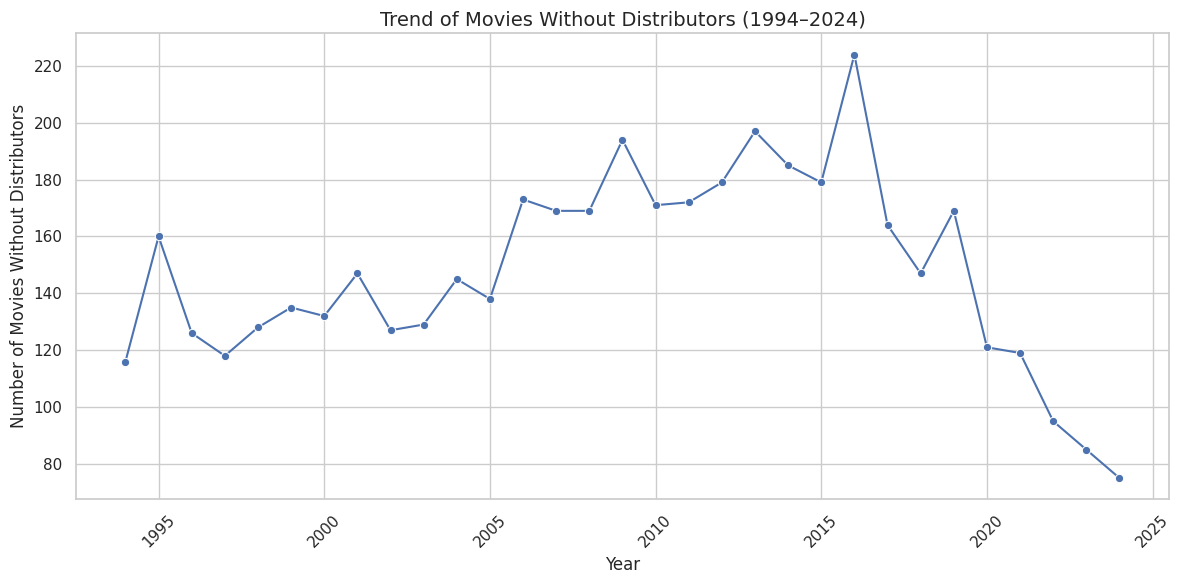

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="Movies Without Distributors", data=df, marker="o", color="b")
plt.title("Trend of Movies Without Distributors (1994–2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Without Distributors", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data scraping from IMDb

In [ ]:
import requests
from bs4 import BeautifulSoup

def fetch_movies(url, headers):
    """Fetch the page content."""
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

def extract_movie_data(soup):
    """Extract movie data based on the IMDb structure."""
    movie_data = []

    # Select the containers for movies
    movie_containers = soup.find_all('div', class_='ipc-metadata-list-summary-item__tc')

    for container in movie_containers:
        # Extract movie title
        title_element = container.find('h3', class_='ipc-title__text')
        movie_name = title_element.text.strip() if title_element else "N/A"

        # Extract release year
        year_element = container.find('span', class_='sc-300a8231-7 eaXxft cli-title-metadata-item')
        release_year = year_element.text.strip() if year_element else "N/A"

        # Extract runtime
        runtime_element = container.find_all('span', class_='sc-300a8231-7 eaXxft cli-title-metadata-item')[1] if len(container.find_all('span', class_='sc-300a8231-7 eaXxft cli-title-metadata-item')) > 1 else None
        runtime = runtime_element.text.strip() if runtime_element else "N/A"

        # Add to movie data
        movie_data.append({
            "Title": movie_name,
            "Year": release_year,
            "Runtime": runtime
        })

    return movie_data

def print_movies(movies):
    """Print all movies."""
    print("Top 250 Movies:")
    for movie in movies:
        print(f"Title: {movie['Title']}, Year: {movie['Year']}, Runtime: {movie['Runtime']}")

# Main program
url = "https://www.imdb.com/chart/top/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

soup = fetch_movies(url, headers)
movies = extract_movie_data(soup)
print_movies(movies)


Top 250 Movies:
Title: 1. The Shawshank Redemption, Year: 1994, Runtime: 2h 22m
Title: 2. The Godfather, Year: 1972, Runtime: 2h 55m
Title: 3. The Dark Knight, Year: 2008, Runtime: 2h 32m
Title: 4. The Godfather Part II, Year: 1974, Runtime: 3h 22m
Title: 5. 12 Angry Men, Year: 1957, Runtime: 1h 36m
Title: 6. The Lord of the Rings: The Return of the King, Year: 2003, Runtime: 3h 21m
Title: 7. Schindler's List, Year: 1993, Runtime: 3h 15m
Title: 8. Pulp Fiction, Year: 1994, Runtime: 2h 34m
Title: 9. The Lord of the Rings: The Fellowship of the Ring, Year: 2001, Runtime: 2h 58m
Title: 10. The Good, the Bad and the Ugly, Year: 1966, Runtime: 2h 58m
Title: 11. Forrest Gump, Year: 1994, Runtime: 2h 22m
Title: 12. The Lord of the Rings: The Two Towers, Year: 2002, Runtime: 2h 59m
Title: 13. Fight Club, Year: 1999, Runtime: 2h 19m
Title: 14. Inception, Year: 2010, Runtime: 2h 28m
Title: 15. Star Wars: Episode V - The Empire Strikes Back, Year: 1980, Runtime: 2h 4m
Title: 16. The Matrix, Year:

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL of the awards page
url = "https://www.imdb.com/name/nm0902939/awards/"

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Fetch the page content
response = requests.get(url, headers=headers)
if response.status_code != 200:
    print(f"Failed to fetch the page. Status code: {response.status_code}")
    exit()

soup = BeautifulSoup(response.content, "html.parser")

# Locate all award entries
award_entries = soup.find_all('li', class_='ipc-metadata-list-summary-item')

# Check if any awards are found
if award_entries:
    for award in award_entries:
        # Extract the year and outcome (e.g., "1995 Nominee")
        year_and_outcome = award.find('a', class_='ipc-metadata-list-summary-item__t')
        year_and_outcome_text = year_and_outcome.text.strip() if year_and_outcome else "N/A"

        # Extract the award name (e.g., "Grand Jury Prize")
        award_name = award.find('span', class_='ipc-metadata-list-summary-item__tst')
        award_name_text = award_name.text.strip() if award_name else "N/A"

        # Extract the award category (e.g., "Dramatic")
        category = award.find('span', class_='ipc-metadata-list-summary-item__li awardCategoryName')
        category_text = category.text.strip() if category else "N/A"

        # Extract the associated work (e.g., "Party Girl")
        associated_work = award.find('a', class_='ipc-metadata-list-summary-item__li ipc-metadata-list-summary-item__li--link')
        associated_work_text = associated_work.text.strip() if associated_work else "N/A"

        # Print the award details
        print(f"Year & Outcome: {year_and_outcome_text}, Award Name: {award_name_text}, "
              f"Category: {category_text}, Associated Work: {associated_work_text}")
else:
    print("No awards found.")

Year & Outcome: 1995 Nominee Grand Jury Prize, Award Name: Grand Jury Prize, Category: Dramatic, Associated Work: Party Girl
Year & Outcome: 2013 Nominee Audience Award, Award Name: Audience Award, Category: Narrative Spotlight, Associated Work: Some Girl(S)
Year & Outcome: 2019 Winner Gracie, Award Name: Gracie, Category: Outstanding Director - Entertainment Series or Special, Associated Work: The Walking Dead
Year & Outcome: 2014 Nominee OFTA Television Award, Award Name: OFTA Television Award, Category: Best Direction in a Comedy Series, Associated Work: Orange Is the New Black
